# Example `Dysmalpy` 2D fitting

**Includes the following components:**

 - Disk + Bulge
 - NFW halo
 - Constant velocity dispersion

#### First import modules

In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

from dysmalpy import galaxy
from dysmalpy import models
from dysmalpy import fitting
from dysmalpy import instrument
from dysmalpy import data_classes
from dysmalpy import parameters
from dysmalpy import plotting
from dysmalpy import aperture_classes

import os
import copy

import numpy as np
import astropy.units as u
import astropy.io.fits as fits

In [2]:
# A check for compatibility:
import emcee
if np.int(emcee.__version__[0]) >= 3:
    ftype_sampler = 'h5'
else:
    ftype_sampler = 'pickle' 

##### Setup notebook

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import Image

In [4]:
import logging
logger = logging.getLogger('DysmalPy')
logger.setLevel(logging.INFO)

#### Set data, output paths

In [5]:
# Data directory
data_dir = '/Users/sedona/data/dysmalpy_example_data/'
#'/YOUR/DATA/PATH/'

# Where to save output files
#outdir  = './output_2D/'
outdir = '/Users/sedona/data/dysmalpy_test_examples/JUPYTER_OUTPUT_2D/'

-------------------

##### Load the function to tie the scale height to the disk effective radius

In [6]:
from dysmalpy.fitting_wrappers.tied_functions import tie_sigz_reff

##### Load the function to tie Mvirial to $f_{DM}(R_e)$

In [7]:
from dysmalpy.fitting_wrappers.tied_functions import tie_lmvirial_NFW

----------

## Initialize galaxy, model set, instrument

In [8]:
gal = galaxy.Galaxy(z=1.613, name='GS4_43501')
mod_set = models.ModelSet()
inst = instrument.Instrument()

### Baryonic component: Combined Disk+Bulge

In [9]:
total_mass = 11.0    # M_sun
bt = 0.3             # Bulge-Total ratio
r_eff_disk = 5.0     # kpc
n_disk = 1.0
invq_disk = 5.0
r_eff_bulge = 1.0    # kpc
n_bulge = 4.0
invq_bulge = 1.0
noord_flat = True    # Switch for applying Noordermeer flattening

# Fix components
bary_fixed = {'total_mass': False,
              'r_eff_disk': False, #True,
              'n_disk': True,
              'r_eff_bulge': True,
              'n_bulge': True,
              'bt': True}

# Set bounds
bary_bounds = {'total_mass': (10, 13),
               'r_eff_disk': (1.0, 30.0),
               'n_disk': (1, 8),
               'r_eff_bulge': (1, 5),
               'n_bulge': (1, 8),
               'bt': (0, 1)}

bary = models.DiskBulge(total_mass=total_mass, bt=bt,
                        r_eff_disk=r_eff_disk, n_disk=n_disk,
                        invq_disk=invq_disk,
                        r_eff_bulge=r_eff_bulge, n_bulge=n_bulge,
                        invq_bulge=invq_bulge,
                        noord_flat=noord_flat,
                        name='disk+bulge',
                        fixed=bary_fixed, bounds=bary_bounds)

bary.r_eff_disk.prior = parameters.BoundedGaussianPrior(center=5.0, stddev=1.0)

### Halo component

In [10]:
mvirial = 12.0
conc = 5.0
fdm = 0.5

halo_fixed = {'mvirial': False,
              'conc': True, 
              'fdm':  False}
# Mvirial will be tied -- so must set 'fixed=False' for Mvirial...

halo_bounds = {'mvirial': (10, 13),
               'conc': (1, 20),
               'fdm': (0, 1)}

halo = models.NFW(mvirial=mvirial, conc=conc, fdm=fdm, z=gal.z,
                  fixed=halo_fixed, bounds=halo_bounds, name='halo')


halo.mvirial.tied = tie_lmvirial_NFW

### Dispersion profile

In [11]:
sigma0 = 39.   # km/s
disp_fixed = {'sigma0': False}
disp_bounds = {'sigma0': (5, 300)}

disp_prof = models.DispersionConst(sigma0=sigma0, fixed=disp_fixed,
                                          bounds=disp_bounds, name='dispprof')

### z-height profile

In [12]:
sigmaz = 0.9   # kpc
zheight_fixed = {'sigmaz': False}

zheight_prof = models.ZHeightGauss(sigmaz=sigmaz, name='zheightgaus',
                                   fixed=zheight_fixed)
zheight_prof.sigmaz.tied = tie_sigz_reff

### Geometry

In [13]:
inc = 62.     # degrees
pa = 142.     # degrees, blue-shifted side CCW from north
xshift = 0    # pixels from center
yshift = 0    # pixels from center
vel_shift = 0 # velocity shift at center ; km/s
geom_fixed = {'inc': False,
              'pa': False,
              'xshift': False,
              'yshift': False,
              'vel_shift': False}

geom_bounds = {'inc': (52, 72),
               'pa': (132, 152),
               'xshift': (-2.5, 2.5),
               'yshift': (-2.5, 2.5),
               'vel_shift': (-100, 100)}

geom = models.Geometry(inc=inc, pa=pa, xshift=xshift, yshift=yshift, vel_shift=vel_shift, 
                       fixed=geom_fixed, bounds=geom_bounds, name='geom')

geom.inc.prior = parameters.BoundedSineGaussianPrior(center=62, stddev=0.1)

## Add all model components to ModelSet

In [14]:
# Add all of the model components to the ModelSet
mod_set.add_component(bary, light=True)
mod_set.add_component(halo)
mod_set.add_component(disp_prof)
mod_set.add_component(zheight_prof)
mod_set.add_component(geom)

### Set kinematic options for calculating velocity profile

In [15]:
mod_set.kinematic_options.adiabatic_contract = False
mod_set.kinematic_options.pressure_support = True

### Set up the instrument

In [16]:
beamsize = 0.55*u.arcsec                 # FWHM of beam
sig_inst = 45*u.km/u.s                   # Instrumental spectral resolution

beam = instrument.GaussianBeam(major=beamsize)
lsf = instrument.LSF(sig_inst)

inst.beam = beam
inst.lsf = lsf
inst.pixscale = 0.125*u.arcsec           # arcsec/pixel
inst.fov = [27, 27]                      # (nx, ny) pixels
inst.spec_type = 'velocity'              # 'velocity' or 'wavelength'
inst.spec_step = 10*u.km/u.s             # Spectral step
inst.spec_start = -1000*u.km/u.s         # Starting value of spectrum
inst.nspec = 201                         # Number of spectral pixels

# Set the beam kernel so it doesn't have to be calculated every step
inst.set_beam_kernel()
inst.set_lsf_kernel()

## Add the model set, instrument to the Galaxy

In [17]:
gal.model = mod_set
gal.instrument = inst

## Load data

* Load the data from file:
  - *2D velocity, dispersion maps and error*
  - *A mask can be loaded / created as well*
  
* Put data in `Data2D` class

* Add data to Galaxy object

In [18]:
gal_vel = fits.getdata(data_dir+'GS4_43501_Ha_vm.fits')
gal_disp = fits.getdata(data_dir+'GS4_43501_Ha_dm.fits')

err_vel = fits.getdata(data_dir+'GS4_43501_Ha_vm_err.fits')
err_disp = fits.getdata(data_dir+'GS4_43501_Ha_dm_err.fits')

mask = fits.getdata(data_dir+'GS4_43501_Ha_m.fits')

#gal_disp[(gal_disp > 1000.) | (~np.isfinite(gal_disp))] = -1e6
#mask[(gs4_disp < 0)] = 0

inst_corr = True                  # Flag for if the measured dispersion has been
                                  # corrected for instrumental resolution

# Mask NaNs:
mask[~np.isfinite(gal_vel)] = 0
gal_vel[~np.isfinite(gal_vel)] = 0.

mask[~np.isfinite(err_vel)] = 0
err_vel[~np.isfinite(err_vel)] = 0.

mask[~np.isfinite(gal_disp)] = 0
gal_disp[~np.isfinite(gal_disp)] = 0.

mask[~np.isfinite(err_disp)] = 0
err_disp[~np.isfinite(err_disp)] = 0.
    

# Put data in Data2D data class: 
#    ** specifies data pixscale as well **
data2d = data_classes.Data2D(pixscale=inst.pixscale.value, velocity=gal_vel,
                                  vel_disp=gal_disp, vel_err=err_vel,
                                  vel_disp_err=err_disp, mask=mask, 
                                  inst_corr=inst_corr)

# Use moment for extraction -- on single pixel scale it does not 
#     appear to strongly impact the results, and it's faster
data2d.moment = True

# Add data to Galaxy object:
gal.data = copy.deepcopy(data2d)

-----------------

## MPFIT Fitting

### MPFIT fitting parameters:

In [19]:
# Options passed to MPFIT:
##maxiter = 200
maxiter = 300

# Other options:
do_plotting = True       # Plot bestfit, corner, trace or not
oversample = 1           # Factor by which to oversample model (eg, subpixels)
fitdispersion = True     # Fit dispersion profile in addition to velocity

outdir_mpfit = outdir+'MPFIT/'

# Choose plot filetype:
plot_type = 'png'

### Run `Dysmalpy` fitting: MPFIT

In [20]:
mpfit_results = fitting.fit_mpfit(gal, oversample=oversample,
                                        fitdispersion=fitdispersion,
                                        maxiter=maxiter,
                                        do_plotting=do_plotting,
                                        outdir=outdir_mpfit,
                                        plot_type=plot_type, overwrite=True)

INFO:DysmalPy:*************************************
INFO:DysmalPy: Fitting: GS4_43501 using MPFIT
INFO:DysmalPy:
mvirial_tied: <function tie_lmvirial_NFW at 0x1a18409730>
INFO:DysmalPy:nSubpixels: 1
INFO:DysmalPy:
MPFIT Fitting:
Start: 2020-10-23 19:14:05.681910

INFO:DysmalPy:Iter 1  CHI-SQUARE = 20600.71671  DOF = 403
   disk+bulge:total_mass = 11  
   disk+bulge:r_eff_disk = 5  
   halo:fdm = 0.5  
   dispprof:sigma0 = 39  
   geom:inc = 62  
   geom:pa = 142  
   geom:xshift = 0  
   geom:yshift = 0  
   geom:vel_shift = 0  

INFO:DysmalPy:Iter 2  CHI-SQUARE = 11560.89051  DOF = 403
   disk+bulge:total_mass = 10.94862679  
   disk+bulge:r_eff_disk = 5.245618654  
   halo:fdm = 0.4542198013  
   dispprof:sigma0 = 34.03347231  
   geom:inc = 72  
   geom:pa = 142.623154  
   geom:xshift = 0.02847145067  
   geom:yshift = -0.03587841886  
   geom:vel_shift = 5.206621043  

INFO:DysmalPy:Iter 3  CHI-SQUARE = 1884.514028  DOF = 403
   disk+bulge:total_mass = 10.87356599  
   disk+bulge:

### Examine MPFIT results

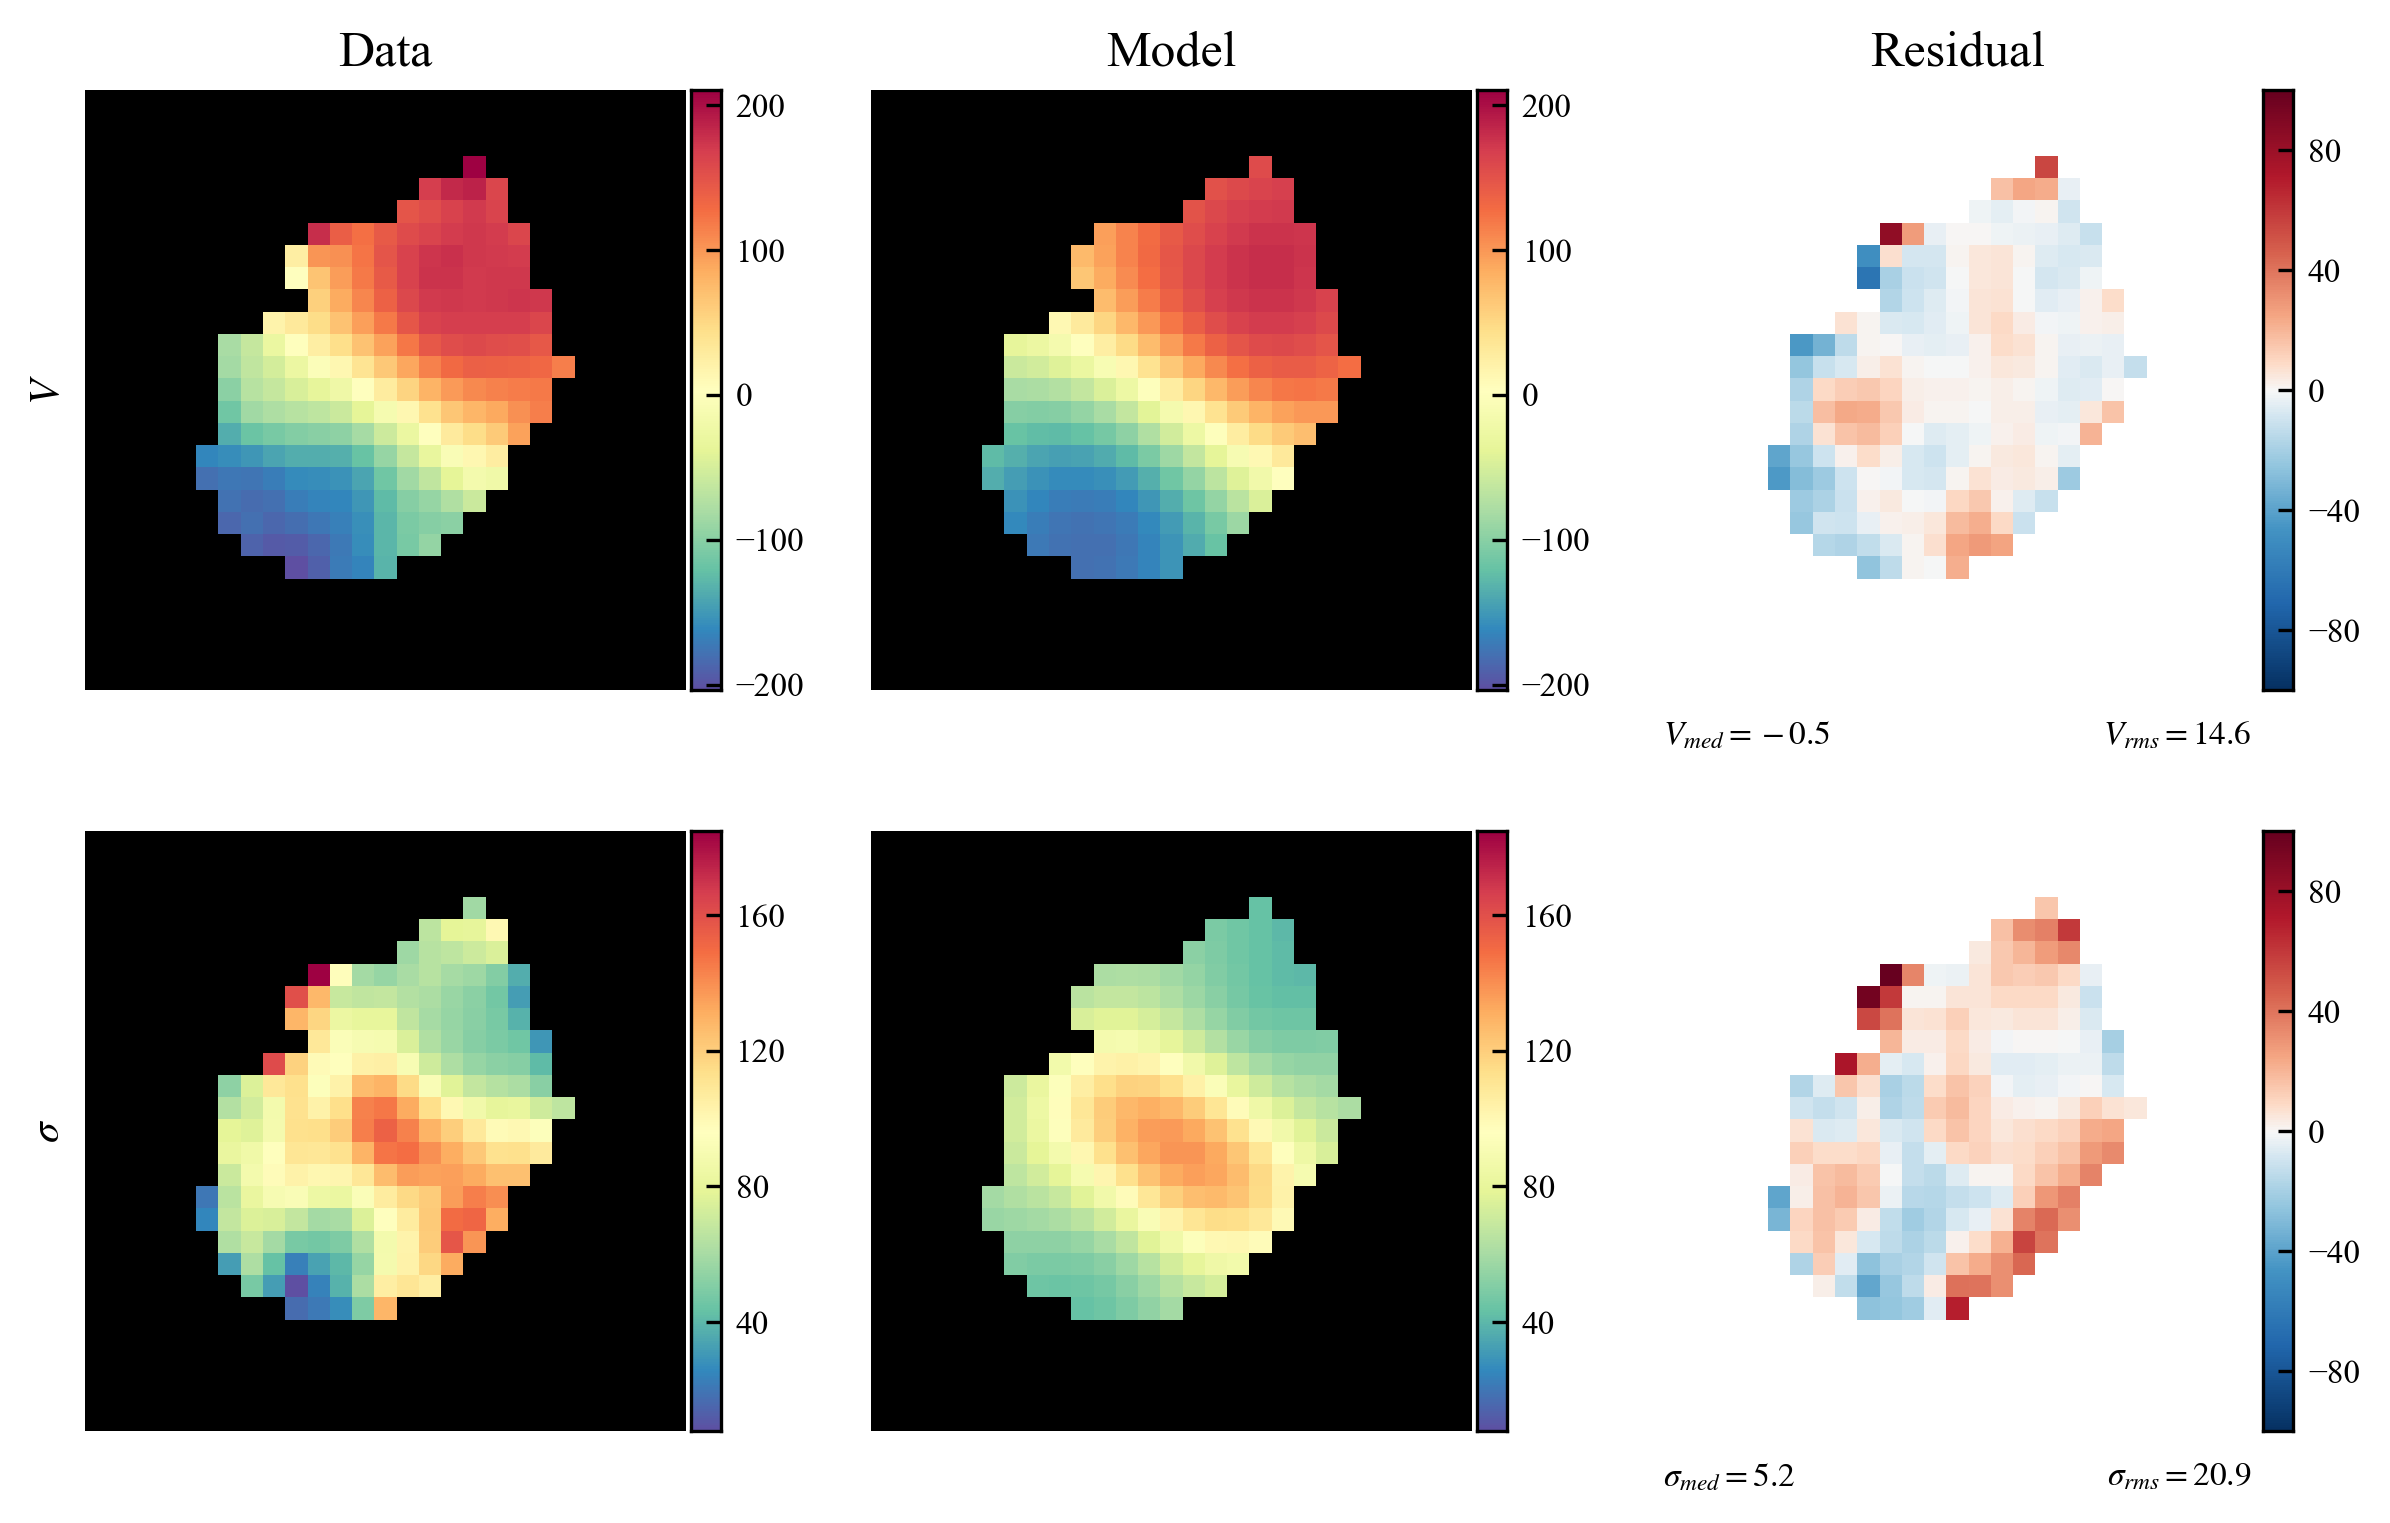

In [21]:
# Look at best-fit:
filepath = outdir_mpfit+"mpfit_best_fit.{}".format(plot_type)
Image(filename=filepath, width=600)

#### Reload the galaxy, results files:

In [22]:
f_galmodel =       outdir_mpfit + 'galaxy_model.pickle'
f_mpfit_results =  outdir_mpfit + 'mpfit_results.pickle'

gal, mpfit_results = fitting.reload_all_fitting(filename_galmodel=f_galmodel, 
                            filename_results=f_mpfit_results, fit_method='mpfit')

#### Plot the best-fit results:

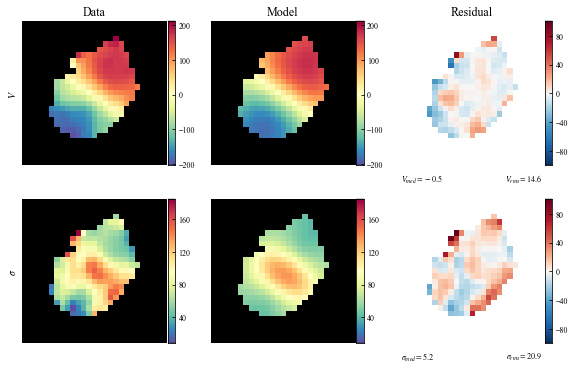

In [23]:
mpfit_results.plot_results(gal, fitdispersion=fitdispersion, 
                          oversample=oversample,
                          f_plot_bestfit=None)

### Print results report:

In [24]:
# Print report
print(mpfit_results.results_report(gal=gal))

###############################
 Fitting for GS4_43501

Date: 2020-10-23 19:15:11.669307


Fitting method: MPFIT

pressure_support_type: 1

###############################
 Fitting results
-----------
 disk+bulge
    total_mass       10.8599  +/-   0.0254
    r_eff_disk        3.8907  +/-   0.2338

    n_disk            1.0000  [FIXED]
    r_eff_bulge       1.0000  [FIXED]
    n_bulge           4.0000  [FIXED]
    bt                0.3000  [FIXED]
-----------
 halo
    fdm               0.1508  +/-   0.0167

    mvirial          11.5078  [TIED]
    conc              5.0000  [FIXED]
-----------
 dispprof
    sigma0           33.3412  +/-   1.2821
-----------
 zheightgaus
    sigmaz            0.6609  [TIED]
-----------
 geom
    inc              69.6290  +/-   1.4900
    pa              146.7415  +/-   0.3764
    xshift            0.2397  +/-   0.0737
    yshift           -0.9474  +/-   0.0429
    vel_shift        14.6284  +/-   0.7718

-----------
Adiabatic contraction: False

--------

### Or save results report to file:

In [25]:
# Save report to file:
f_mpfit_report = outdir_mpfit + 'mpfit_fit_report.txt'
mpfit_results.results_report(gal=gal, filename=f_mpfit_report)

-----------------

## MCMC Fitting

##### Get a clean copy of model, instrument

In [26]:
gal            = galaxy.Galaxy(z=1.613, name='GS4_43501')
gal.data       = copy.deepcopy(data2d)
gal.model      = copy.deepcopy(mod_set)
gal.instrument = copy.deepcopy(inst)

### MCMC fitting parameters ###

Set parameters for fitting: 
   - Passing options to `emcee`
   - Other calculation options

In [27]:
# Options passed to emcee
# SHORT TEST:
nwalkers = 20
ncpus = 4
scale_param_a = 5 #3
# The walkers were not exploring the parameter space well with scale_param_a = 3, 
#     but were getting 'stuck'. So to improve the walker movement with larger 
#     'stretch' in the steps, we increased scale_param_a.
nburn = 2
nsteps = 5
minaf = None
maxaf = None
neff = 10

# Other options
do_plotting = True       # Plot bestfit, corner, trace or not
oversample = 1           # Factor by which to oversample model (eg, subpixels)
fitdispersion = True     # Fit dispersion profile in addition to velocity

blob_name = 'mvirial'    # Also save 'blob' values of Mvirial, calculated at every chain step

outdir_mcmc = outdir + 'MCMC/'

# Choose plot filetype:
plot_type = 'png'

-------

## Run `Dysmalpy` fitting: MCMC

In [28]:
mcmc_results = fitting.fit_mcmc(gal, nWalkers=nwalkers, nCPUs=ncpus,
                               scale_param_a=scale_param_a, nBurn=nburn,
                               nSteps=nsteps, minAF=minaf, maxAF=maxaf,
                               nEff=neff, do_plotting=do_plotting,
                               oversample=oversample, outdir=outdir_mcmc,
                               fitdispersion=fitdispersion,
                               blob_name=blob_name, 
                               plot_type=plot_type, overwrite=True)

INFO:DysmalPy:*************************************
INFO:DysmalPy: Fitting: GS4_43501 with MCMC
INFO:DysmalPy:
nCPUs: 4
INFO:DysmalPy:nWalkers: 20
INFO:DysmalPy:lnlike: red_chisq=False
INFO:DysmalPy:lnlike: oversampled_chisq=True
INFO:DysmalPy:
blobs: mvirial
INFO:DysmalPy:
mvirial_tied: <function tie_lmvirial_NFW at 0x1a18409730>
INFO:DysmalPy:nSubpixels: 1
INFO:DysmalPy:
Burn-in:
Start: 2020-10-23 19:15:12.262225

INFO:DysmalPy: k=0, time.time=2020-10-23 19:15:12.264561, a_frac=nan
INFO:DysmalPy: k=1, time.time=2020-10-23 19:15:20.805293, a_frac=0.15
INFO:DysmalPy:
End: 2020-10-23 19:15:22.667094

******************
nCPU, nParam, nWalker, nBurn = 4, 9, 20, 2
Scale param a= 5
Time= 10.38 (sec),   0:10.38 (m:s)
Mean acceptance fraction: 0.150
Ideal acceptance frac: 0.2 - 0.5
Autocorr est: [nan nan nan nan nan nan nan nan nan]
******************
INFO:DysmalPy:
Ensemble sampling:
Start: 2020-10-23 19:15:26.706140

INFO:DysmalPy:ii=0, a_frac=0.25 time.time()=2020-10-23 19:15:28.561392
INF

### Examine MCMC results

Of course this (very short!) example looks terrible, but it's instructive to see what's happening even if you only did a very short / few walker MCMC test:

### Trace
- The individual walkers should move around in the parameter space over the chain iterations (not necessarily for every step; but there should be ***some*** exploration of the space)

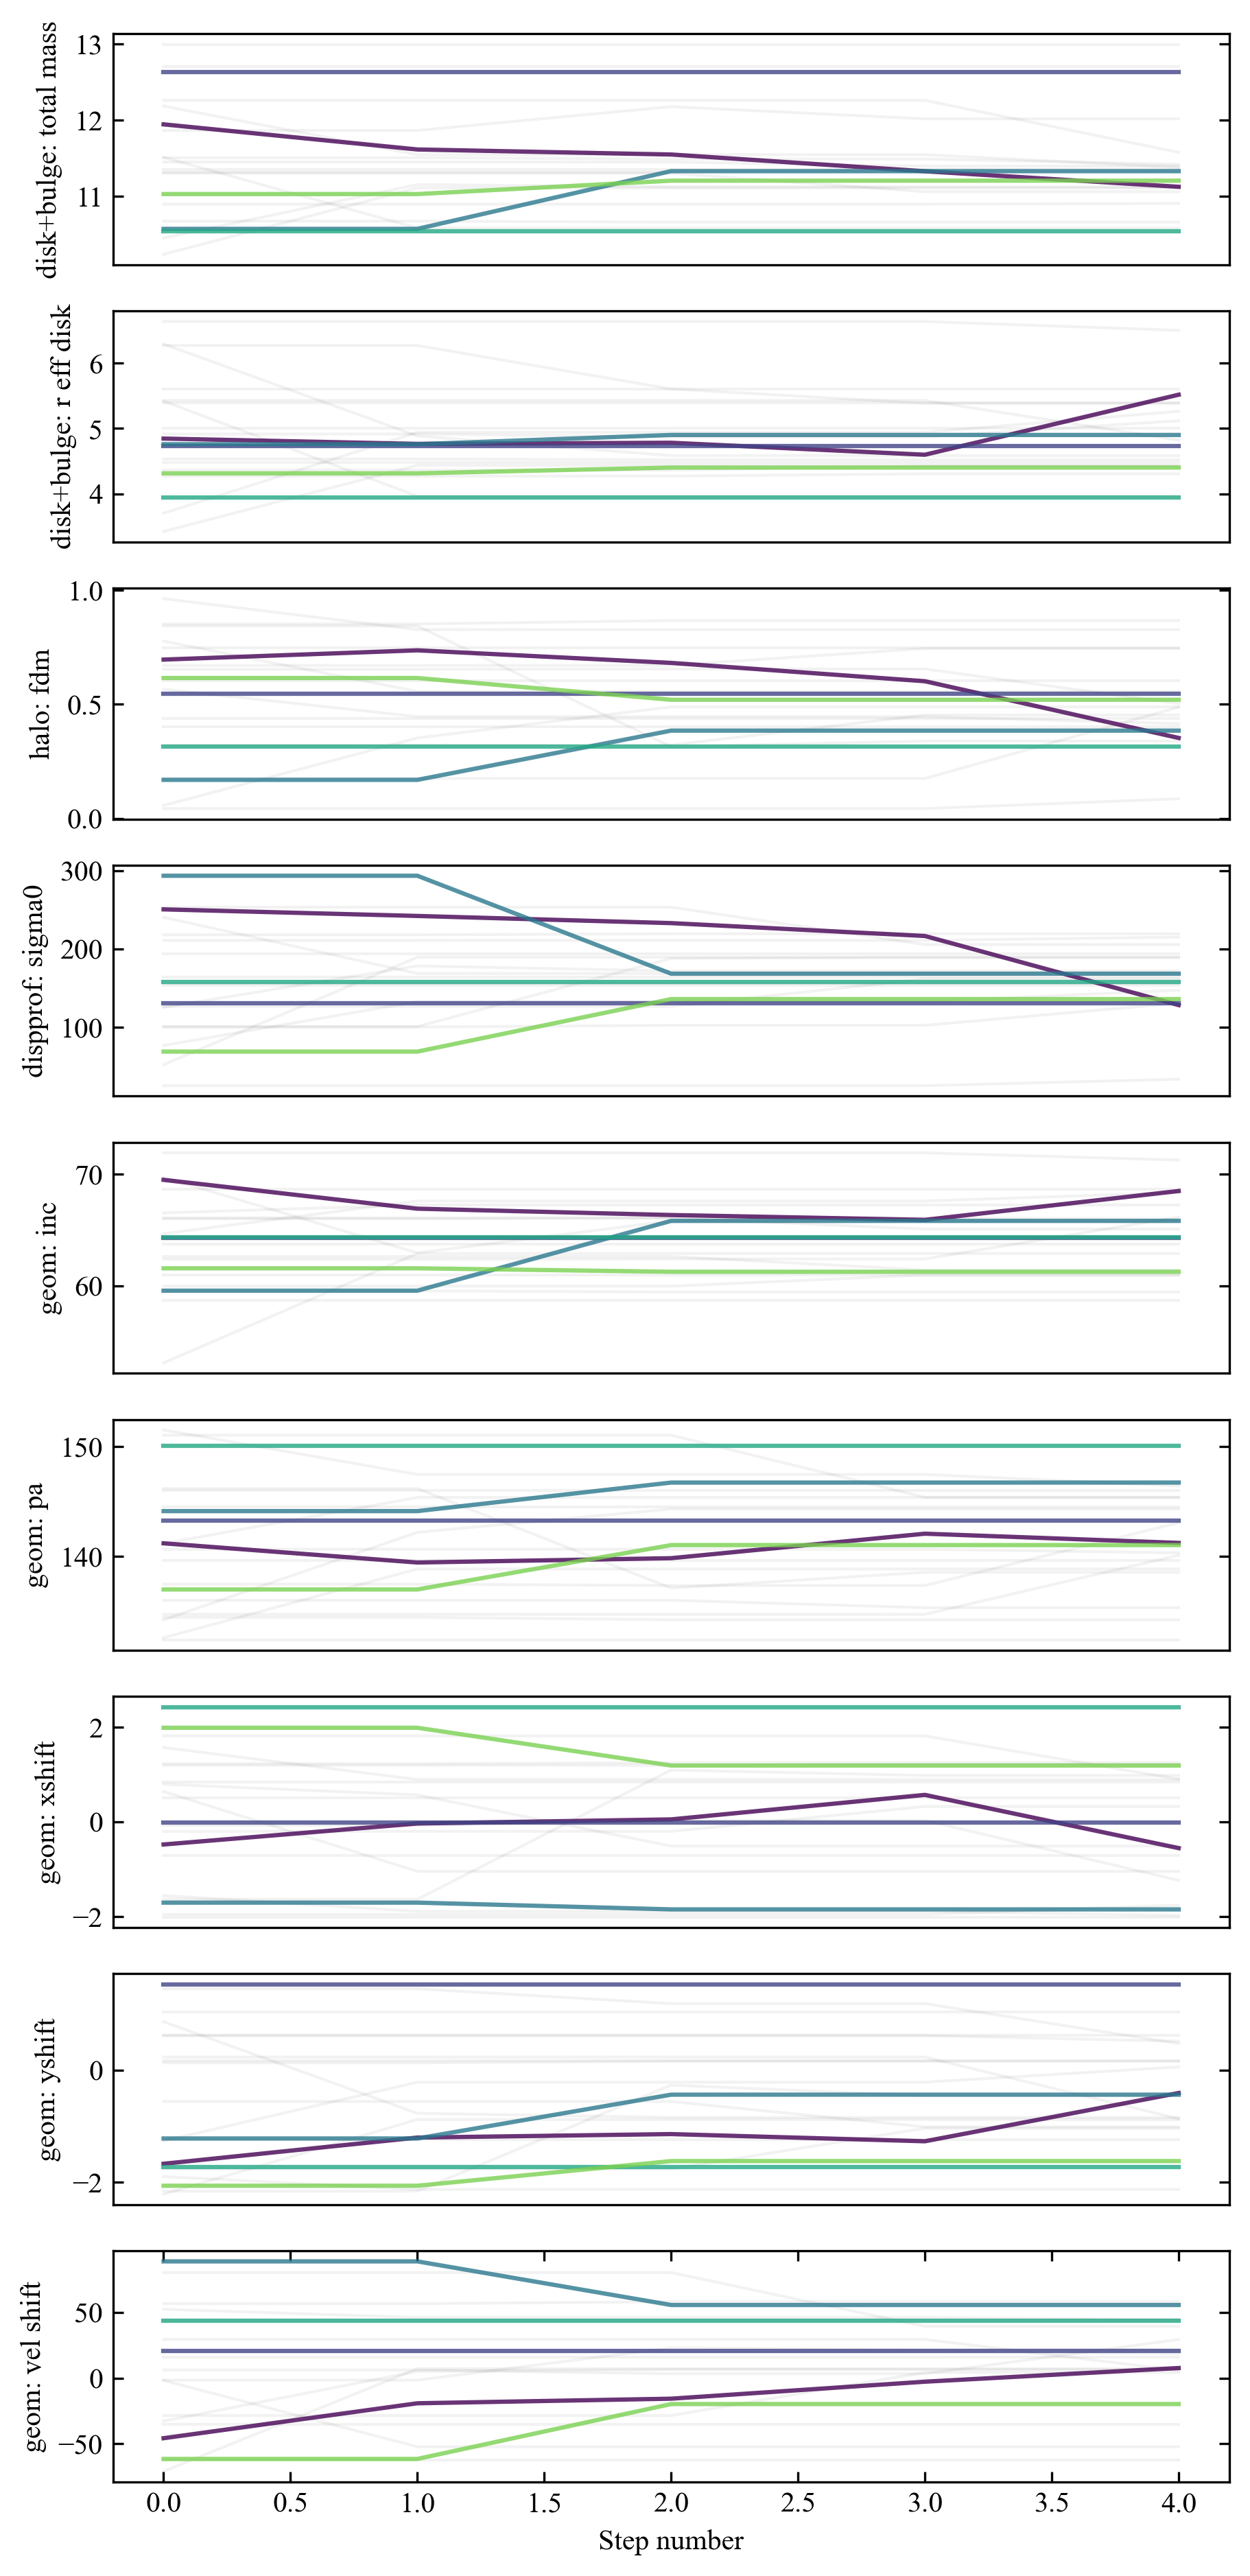

In [29]:
# Look at trace:
filepath = outdir_mcmc+"mcmc_trace.{}".format(plot_type)
Image(filepath, width=600)

### Best-fit
- This is a good opportunity to check that the model PA and slit PA are correct, or else the data and model curves will have opposite shapes!
- Also, it's helpful to check that your data masking is reasonable.
- Finally, this is a worthwhile chance to see if your "nuisance" geometry and spectral parameters (especially `xshift`, `yshift`, `vel_shift` have reasonable values, and if appropriate, reasonable bounds and priors.)

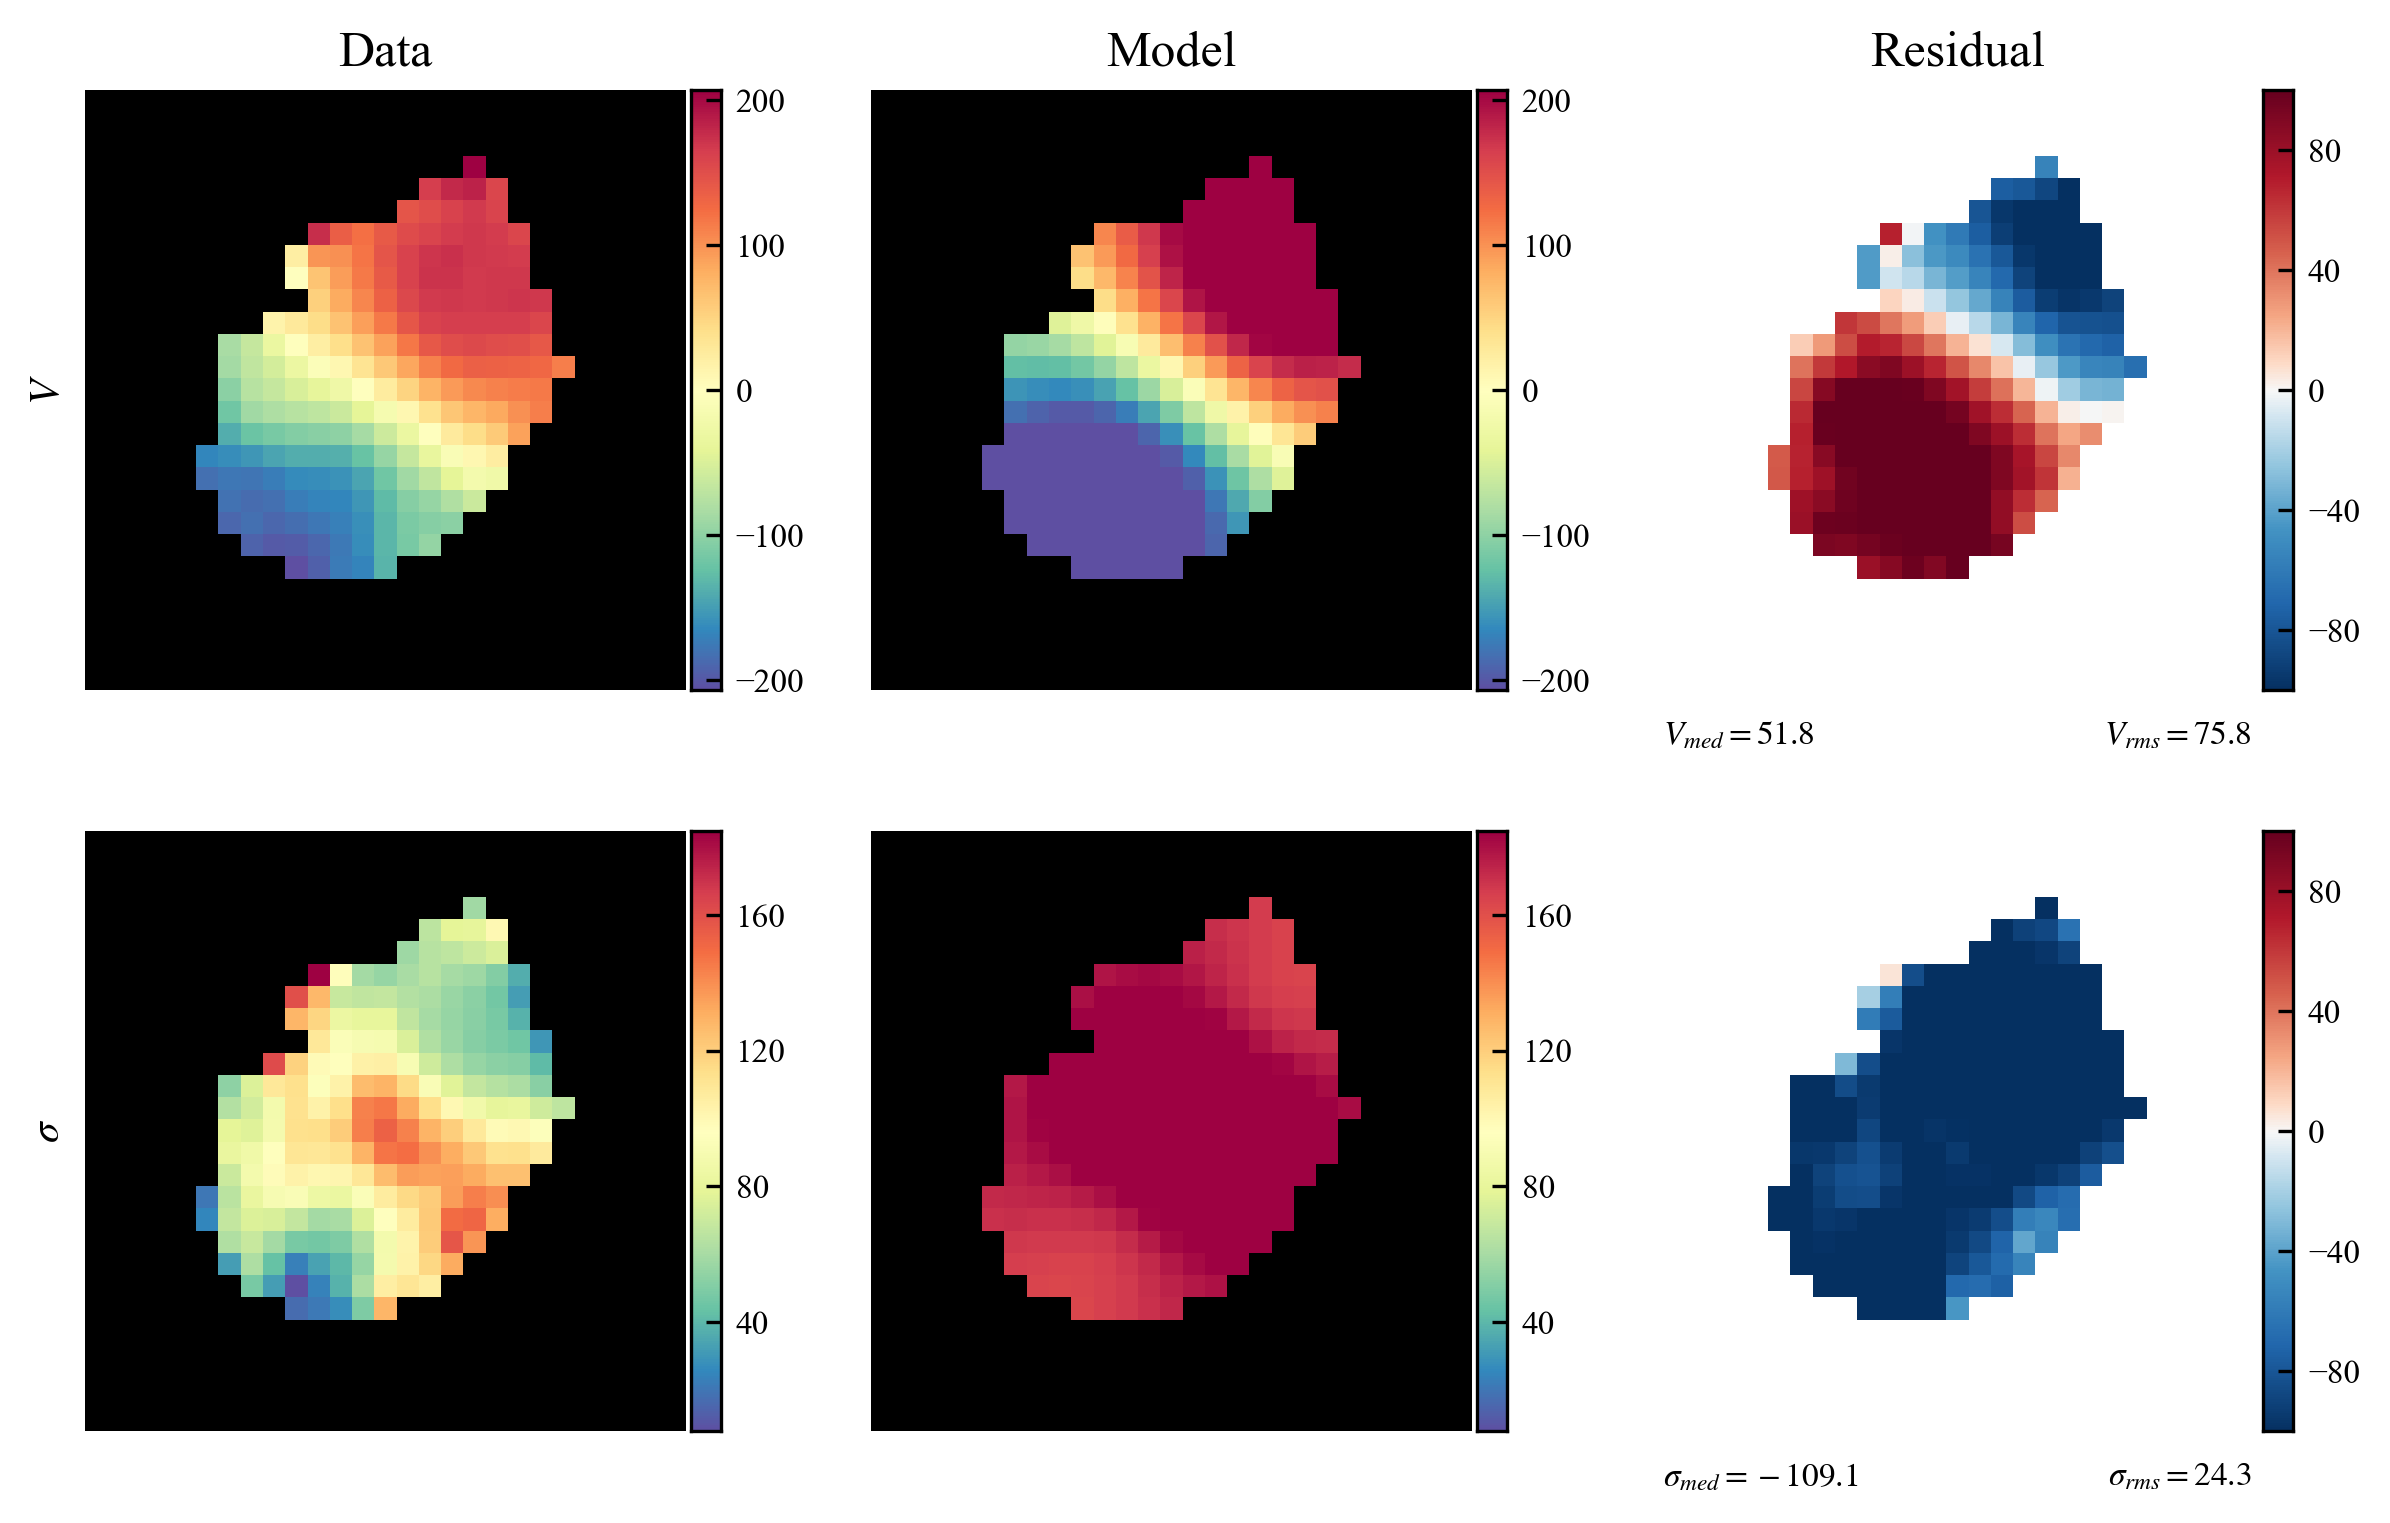

In [30]:
# Look at best-fit:
filepath = outdir_mcmc+"mcmc_best_fit.{}".format(plot_type)
Image(filepath, width=600)

### Sampler "corner" plot
- The "best-fit" MAP (by default taken to be the peak of each marginalized parameter posterior, independent of the other parameters) is marked with the solid blue line. 
  * However, the MAP can also be found by jointly analyzing two or more parameters' posterior space. <p>
       *(&rarr; see the example in the :ref:`1D example fit <dysmalpy_example_fit_1D.ipynb>` tutorial)*
- Check to see that your Gaussian prior centers are marked in orange in the appropriate rows/columns (if any Gaussian priors are used).
- The vertical dashed black lines show the 2.275%, 15.865%, 84.135%, 97.725% percentile intervals for the marginalized posterior for each parameter. 
- The vertical dashed purple lines show the shortest $1\sigma$ interval, determined from the marginalized posterior for each parameter independently. 

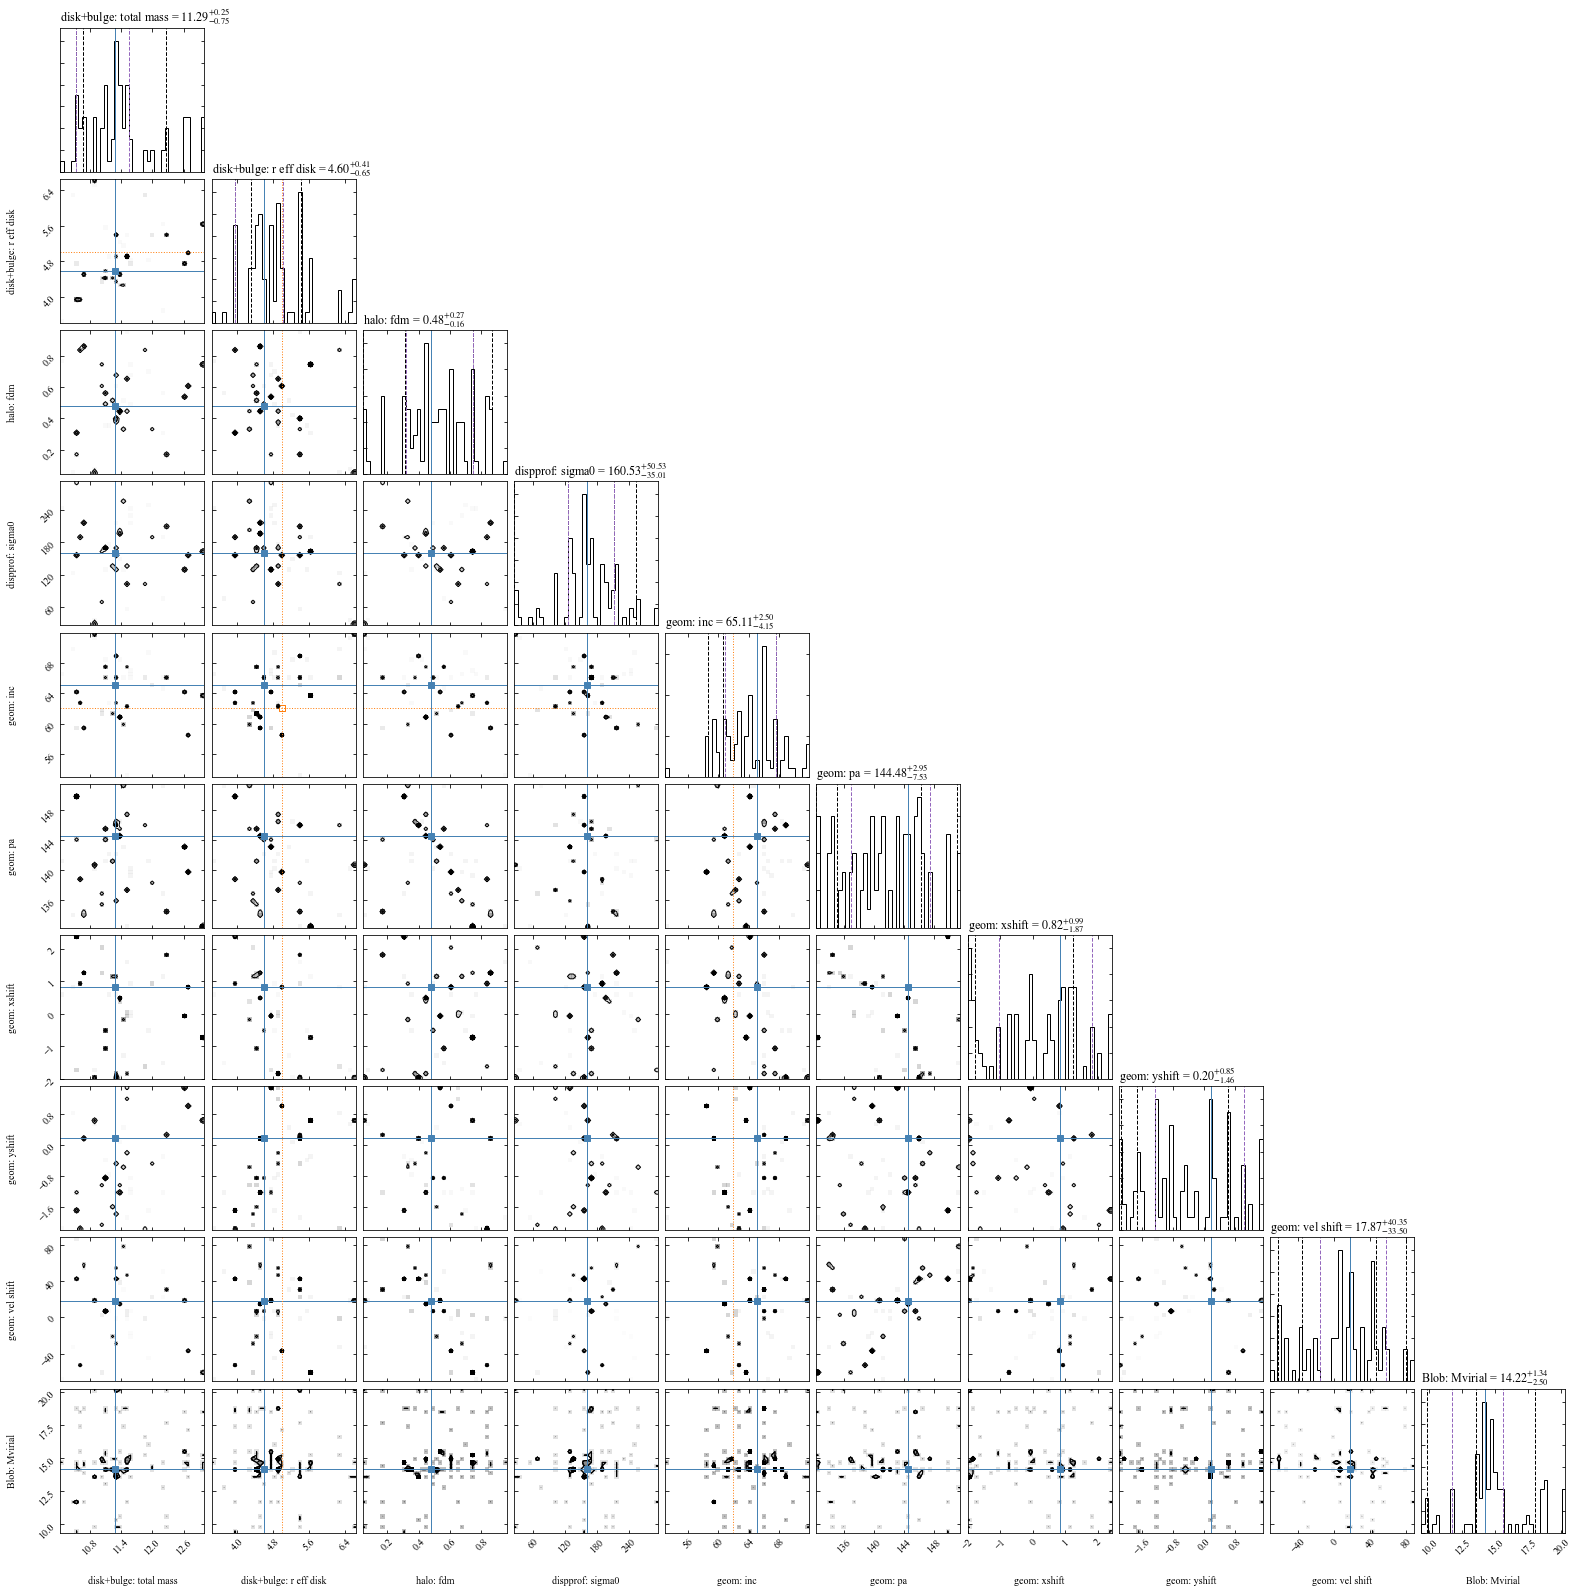

In [31]:
# Look at corner:
filepath = outdir_mcmc+"mcmc_param_corner.{}".format(plot_type)
Image(filepath, height=620)

---------

## Look at a real MCMC example:

In the interest of time, let's look at some results calculated previously.

For this fit, we used 1000 walkers, 175 burn-in steps, and 200 steps. 

Using **190 threads**, it took about **21 minutes** to run the MCMC fit.

In [32]:
outdir_mcmc_full = outdir_mcmc = outdir + 'MCMC_full_run_nw1000_ns200_a5/'

### Load and examine results: ##

Helpful for:
  - replotting
  - reanalyzing chain (eg, jointly constraining some posteriors)
  - ...

#### Reload the galaxy, results files:

In [33]:
f_galmodel = outdir_mcmc_full + 'galaxy_model.pickle'
f_mcmc_results =  outdir_mcmc_full + 'mcmc_results.pickle'

gal, mcmc_results = fitting.reload_all_fitting(filename_galmodel=f_galmodel, 
                            filename_results=f_mcmc_results, fit_method='mcmc')

#### If necessary, also reload the sampler chain:

In [34]:
f_sampler =  outdir_mcmc_full + 'mcmc_sampler.{}'.format(ftype_sampler)
mcmc_results.reload_sampler(filename=f_sampler)

N/10 = 20;
tau: [19.6537326  19.9891195  19.55235249 19.98314067 19.7486466  19.41789169
 19.19654616 20.31377879 19.68237055]


#### Plot the best-fit results:

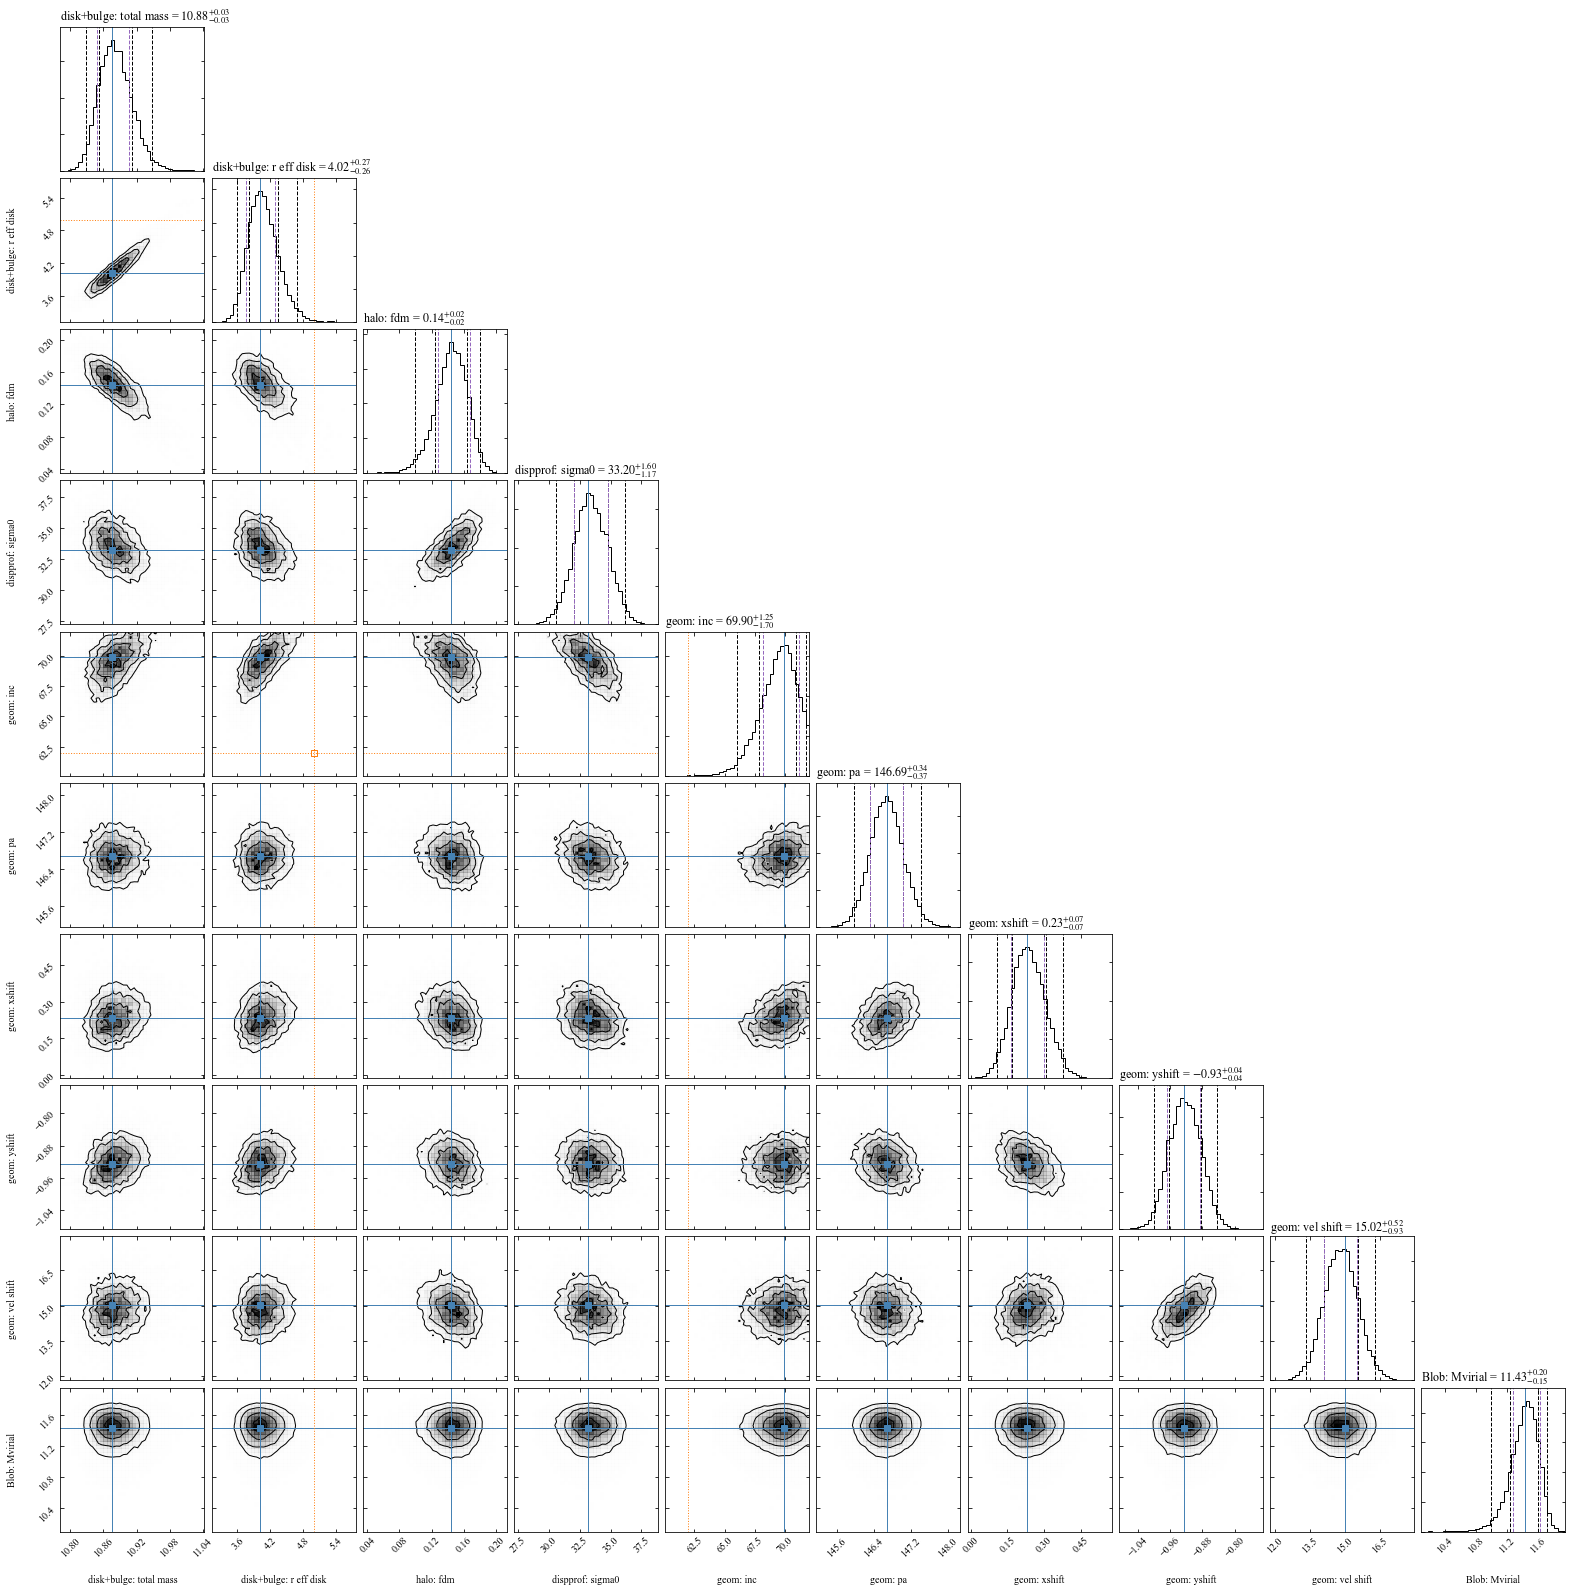

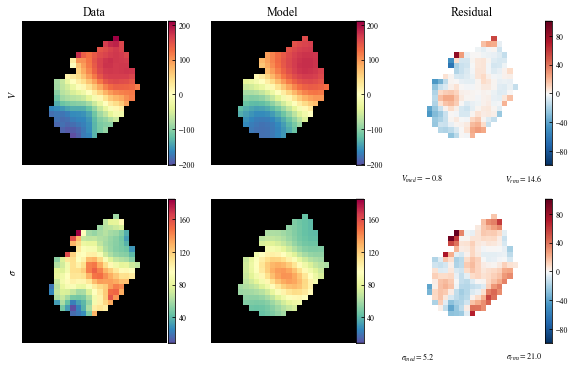

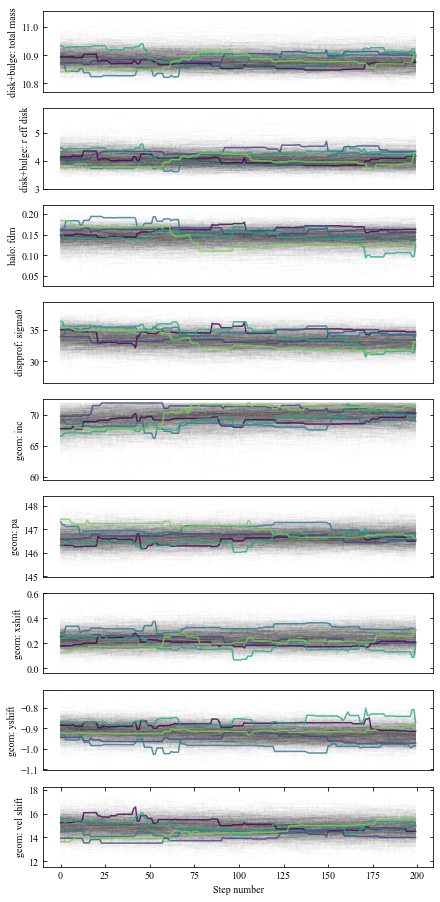

In [35]:
mcmc_results.plot_results(gal, fitdispersion=fitdispersion, 
                          oversample=oversample,
                          f_plot_param_corner=None, 
                          f_plot_bestfit=None, f_plot_trace=None)

### Print results report:

In [36]:
# Print report
print(mcmc_results.results_report(gal=gal))

###############################
 Fitting for GS4_43501

Date: 2020-10-23 19:16:32.649058


Fitting method: MCMC

pressure_support_type: 1

###############################
 Fitting results
-----------
 disk+bulge
    total_mass       10.8755  -   0.0278 +   0.0312
    r_eff_disk        4.0151  -   0.2608 +   0.2707

    n_disk            1.0000  [FIXED]
    r_eff_bulge       1.0000  [FIXED]
    n_bulge           4.0000  [FIXED]
    bt                0.3000  [FIXED]
-----------
 halo
    fdm               0.1433  -   0.0150 +   0.0242

    mvirial          11.4323  [TIED]
    conc              5.0000  [FIXED]
-----------
 dispprof
    sigma0           33.2030  -   1.1670 +   1.6011
-----------
 zheightgaus
    sigmaz            0.6820  [TIED]
-----------
 geom
    inc              69.8972  -   1.6953 +   1.2540
    pa              146.6866  -   0.3726 +   0.3369
    xshift            0.2318  -   0.0688 +   0.0688
    yshift           -0.9261  -   0.0410 +   0.0396
    vel_shift        15

### Or save results report to file:

In [37]:
# Save report to file:
f_mcmc_report = outdir_mcmc + 'mcmc_fit_report.txt'
mcmc_results.results_report(gal=gal, filename=f_mcmc_report)

------